# Processing text queries
- code in this notebook predominantly analyze text queries submitted by participants to solve KIS tasks of VBS 2023
- among others, this notebook can replicate the content of Table 2 and 3 as well as Figures 13-15

In [1]:
import sys
import os
modules_path = os.getcwd() + '/..'
sys.path.insert(0, modules_path)

# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from notebooks.utils import compute_user_penalty, get_team_values_df
from common.load import load_competition_data, process_team_logs

pd.set_option('display.max_colwidth', None)
unknownRankLimit = 1000
unknownRankValue = 2000

# Import common data

In [2]:
config = modules_path +'/config_vbs2023.yaml'

# load competition data from dres files and auxiliary data (FPSs, sequences)
comp_data = load_competition_data(config)

# load the preprocessed query data
dataset = pd.read_pickle(comp_data["config"]["processed_logs_outdir"] + '/text_query_dataset.pkl')

# valid teams
team_order = ['vibro', 'VISIONE',  'vitrivr-VR', 'CVHunter', 'Verge']
#team_order = ['vibro', 'VISIONE', 'VIREO' 'vitrivr-VR', 'CVHunter', 'vitrivr', 'Verge']

dataset.shape

c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_df = self.tasks_df.append({
c:\Lang\Python\VBS23-Post-Hoc-Analysis\src\python\notebooks/..\common\tasks.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.tasks_

(784, 20)

### Creating auxiliary variables
- Query length and volume of words per query
- Maybe also store information whether the query is temporal? Only HTW and VISIONE have obviouse temporal queries
- Define visual vs textual tasks

In [3]:
dataset["task_type"] = "visual"
dataset.loc[dataset.task.str.contains("kis-t"),"task_type"] = "textual"

dataset["query_type"] = "Other"
dataset.loc[dataset.is_joint_embedding_text_query, "query_type"] = "Text"

dataset["QueryLen"] = -1
dataset["QueryWords"] = -1

dataset.loc[dataset["query_type"]=="Text","QueryLen"] = dataset.loc[dataset["query_type"]=="Text","value"].str.len()
dataset.loc[dataset["query_type"]=="Text","QueryWords"] = dataset.loc[dataset["query_type"]=="Text","value"].str.split().str.len()

dataset['user'] = dataset['user'].replace(0, '1st').replace(1, '2nd')

dataset.head()

level_0  index            task   team user      timestamp  \
0          0      0    vbs23-kis-v1  vibro  1st  1673259650000   
112      112    112  vbs23-kis-v-m2  vibro  2nd  1673271280000   
113      113    113  vbs23-kis-v-m3  vibro  2nd  1673271639000   
114      114    114  vbs23-kis-v-m4  vibro  2nd  1673272419000   
115      115    115  vbs23-kis-v-m4  vibro  2nd  1673272427000   

     elapsed_since_task_start_ms  correct_submission_time_ms  rank_video  \
0                          36687                     43981.0         1.0   
112                        29638                     45672.0         1.0   
113                        15343                     24472.0         3.0   
114                        45815                    211429.0       505.0   
115                        53815                    211429.0       393.0   

     rank_shot_margin_0  ...  \
0                   1.0  ...   
112                 4.0  ...   
113                 6.0  ...   
114               505.0  ...   
115               393.0  ...   

                                                 value  additionals  \
0    Man in pink closest standing a basketball stadium           {}   
112                                        video Molok           {}   
113               black and white dotted snake hiding            {}   
114                                 fishes over corals           {}   
115                 fishes over corals with blue water           {}   

    is_user_with_correct_submission is_temporal_query  \
0                               NaN             False   
112                             NaN             False   
113                             NaN             False   
114                             NaN             False   
115                             NaN             False   

    is_joint_embedding_text_query  \
0                            True   
112                         False   
113                          True   
114                          True   
115                          True   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              joint_text_embedding  \
0          [123, 124, -125, -112, -124, -116, -121, 122, -109, 125, -117, -123, 124, -122, 126, -122, -127, 127, 121, -125, 122, -121, 124, 121, -116, 127, -126, -126, -126, 127, 124, -123, 123, -123, -126, 126, 118, 115, 126, -127, 125, 116, 127, 122, 125, -128, 124, -123, -128, -126, -123, 127, -115, -128, -119, 117, -125, 114, 125, -124, -128, -125, 112, 127, 125, 117, 121, -122, -120, -127, 123, 124, 124, 120, 123, 127, -123, 115, 121, 123, -127, -124, 111, 123, 123, -125, 124, 119, -126, 120, -128, -126, -125, 122, 119, 125, 125, 126, -124, -122, ...]   
112                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           None   
113           [-115, -128, 125, 123, 121, -122, 125, -127, -118, 125, 120, 116, 125, 125, 125, 118, 122, -116, -128, 125, 125, -119, -117, -126, 118, 126, -128, -121, -121, -122, 122, -116, -122, 125, -118, 126, 124, 126, 126, 120, 115, -125, -122, -122, 118, -125, 1

In [34]:
dataset.loc[(dataset['is_joint_embedding_text_query'] == False) & (dataset['team'] == 'VISIONE'), ["team", "category", "type", "query_type", "timestamp"]]

team category                                              type  \
192  VISIONE    IMAGE  globalFeatures > sematic video similarity (CLIP)   
186  VISIONE    IMAGE           globalFeatures > image similarity (GEM)   
175  VISIONE    IMAGE           globalFeatures > image similarity (GEM)   
179  VISIONE     TEXT                LocalizedObjectAndColors > classes   
178  VISIONE     TEXT               LocalizedObjectAndColors > position   
176  VISIONE    IMAGE           globalFeatures > image similarity (GEM)   

    query_type      timestamp  
192      Other  1673276066338  
186      Other  1673273158977  
175      Other  1673272478207  
179      Other  1673272765946  
178      Other  1673272765946  
176      Other  1673272617730

# Table 2 in the paper: usage of Text queries

In [4]:
# percentage of how many rows per team belong to a text query and an image query
counts = dataset.groupby(["team","query_type"])[["value"]].count()
counts = ((counts / counts.groupby('team')[["value"]].sum())*100).round(1)

# add empty rows
counts = counts.reset_index()
counts = counts.append(pd.DataFrame([{'team': 'vitrivr-VR', 'query_type': 'Other', 'value': 0}], columns=counts.columns))

# sort in team order
counts = counts.set_index(['team','query_type']).loc[team_order, :]
counts

C:\Users\Neiko\AppData\Local\Temp\ipykernel_10816\1618529372.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  counts = counts.append(pd.DataFrame([{'team': 'vitrivr-VR', 'query_type': 'Other', 'value': 0}], columns=counts.columns))


value
team       query_type       
vibro      Other        47.9
           Text         52.1
VISIONE    Other         3.5
           Text         96.5
vitrivr-VR Text        100.0
           Other         0.0
CVHunter   Other        36.4
           Text         63.6
Verge      Other         8.6
           Text         91.4

In [5]:
print(counts.to_latex())

\begin{tabular}{llr}
\toprule
      &      &  value \\
team & query\_type &        \\
\midrule
vibro & Other &   47.9 \\
      & Text &   52.1 \\
VISIONE & Other &    3.5 \\
      & Text &   96.5 \\
vitrivr-VR & Text &  100.0 \\
      & Other &    0.0 \\
CVHunter & Other &   36.4 \\
      & Text &   63.6 \\
Verge & Other &    8.6 \\
      & Text &   91.4 \\
\bottomrule
\end{tabular}



C:\Users\Neiko\AppData\Local\Temp\ipykernel_10816\1484047370.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(counts.to_latex())


# Table 3

In [6]:
# median values
dataset.loc[dataset.rank_video > unknownRankLimit, "rank_video"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_0 > unknownRankLimit, "rank_shot_margin_0"] = unknownRankValue
dataset.loc[dataset.rank_shot_margin_5 > unknownRankLimit, "rank_shot_margin_5"] = unknownRankValue
medianStats = dataset.groupby(["team","user","query_type"])[["rank_shot_margin_0","rank_shot_margin_5","rank_video"]].median()

# mean query length and word count
meanQueryStats = dataset.groupby(["team","user","query_type"])[["QueryWords","QueryLen"]].mean()

# query count per team, user and query_type
queryCount = dataset.groupby(["team", "user", "query_type", "timestamp"])['task'].count().reset_index()
queryCount = queryCount.groupby(["team", "user", "query_type"]).count()
queryCount = queryCount['task']
queryUsage = ((queryCount / dataset.groupby(["team", "user"])['task'].count())*100).round(1)

# construct table
restrData = dataset
top5 = restrData.loc[restrData.rank_shot_margin_0 < 5].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top10 = restrData.loc[restrData.rank_shot_margin_0 < 10].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top20 = restrData.loc[restrData.rank_shot_margin_0 < 20].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top50 = restrData.loc[restrData.rank_shot_margin_0 < 50].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top100 = restrData.loc[restrData.rank_shot_margin_0 < 100].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top200 = restrData.loc[restrData.rank_shot_margin_0 < 200].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]
top500 = restrData.loc[restrData.rank_shot_margin_0 < 500].groupby(["team","user","query_type"]).count()["rank_shot_margin_0"]

resTab1 = pd.DataFrame({"total queries":queryCount,
                        "queries usage":queryUsage,
                        "words / query": 0,
                        "query length": 0,
                        "top5":(top5/queryCount*100).round(1),
                        "top10":(top10/queryCount*100).round(1),
                        "top20":(top20/queryCount*100).round(1),
                        "top50":(top50/queryCount*100).round(1),
                        "top100":(top100/queryCount*100).round(1),
                        "top200":(top200/queryCount*100).round(1),
                        "top500":(top500/queryCount*100).round(1)}).fillna(0)

# in the end we want mean stats
resTab1["words / query"] = meanQueryStats["QueryWords"]
resTab1["query length"] = meanQueryStats["QueryLen"]

# sort in team order
resTab1 = resTab1.loc[team_order, :]
resTab1

total queries  queries usage  words / query  \
team       user query_type                                                
vibro      1st  Other                  38           50.0      -1.000000   
                Text                   38           50.0      10.078947   
           2nd  Other                  42           46.2      -1.000000   
                Text                   49           53.8       7.163265   
VISIONE    1st  Text                   50          100.0      20.400000   
           2nd  Other                   5            4.1      -1.000000   
                Text                  117           95.1      15.076923   
vitrivr-VR 1st  Text                   38          100.0       7.578947   
           2nd  Text                   23          100.0       5.086957   
CVHunter   1st  Other                  29           27.6      -1.000000   
                Text                   76           72.4      11.776316   
           2nd  Other                  55           43.7      -1.000000   
                Text                   71           56.3       7.000000   
Verge      1st  Other                  13            8.6      -1.000000   
                Text                  121           79.6       5.000000   

                            query length  top5  top10  top20  top50  top100  \
team       user query_type                                                    
vibro      1st  Other          -1.000000   2.6    5.3   13.2   28.9    36.8   
                Text           52.447368  10.5   13.2   21.1   34.2    39.5   
           2nd  Other          -1.000000   2.4    2.4    9.5   19.0    26.2   
                Text           38.265306   6.1   10.2   18.4   24.5    28.6   
VISIONE    1st  Text          106.040000  10.0   10.0   16.0   30.0    38.0   
           2nd  Other          -1.000000  20.0   20.0   20.0   40.0    40.0   
                Text           76.136752   8.5   11.1   17.1   23.9    29.1   
vitrivr-VR 1st  Text           38.342105   5.3   13.2   18.4   21.1    23.7   
           2nd  Text           26.782609   0.0    4.3    4.3    4.3     4.3   
CVHunter   1st  Other          -1.000000  10.3   10.3   10.3   13.8    24.1   
                Text           63.881579   3.9   17.1   18.4   21.1    27.6   
           2nd  Other          -1.000000   1.8    1.8    7.3   12.7    18.2   
                Text           40.718310   4.2    4.2    5.6    8.5    12.7   
Verge      1st  Other          -1.000000   7.7   15.4   15.4   15.4    23.1   
                Text           28.165468   0.8    0.8    1.7    3.3     5.0   

                            top200  top500  
team       user query_type                  
vibro      1st  Other         39.5    47.4  
                Text          47.4    57.9  
           2nd  Other         33.3    59.5  
                Text          32.7    44.9  
VISIONE    1st  Text          46.0    60.0  
           2nd  Other         60.0    60.0  
                Text          40.2    53.8  
vitrivr-VR 1st  Text          28.9    28.9  
           2nd  Text          17.4    17.4  
CVHunter   1st  Other         34.5    55.2  
                Text          35.5    48.7  
           2nd  Other         20.0    30.9  
                Text          23.9    35.2  
Verge      1st  Other         23.1    30.8  
                Text          31.4    39.7

## add queries per minute to table 3

In [13]:
# total availabe time to ask queries per team
totTime = dataset.groupby(["team", "task"])[["correct_submission_time_ms"]].min().reset_index().groupby(["team"])["correct_submission_time_ms"].sum()

# query per minute per user, team and query type
queryPerMinute = queryCount/totTime*1000*60
qpmdf = pd.DataFrame({"QPM": queryPerMinute})

# table 3
tab3 = resTab1.reset_index().set_index(['team', 'user', 'query_type'])

# copy queries per minute column for all clip rows
tab3["query / minute"] = qpmdf["QPM"]

# Replace NaN values with zeros
tab3 = tab3.fillna(0)
                   
# Replace -1 with 0
tab3 = tab3.replace(-1, 0)

# combine query count and usage columns
tab3["usage"] = tab3["total queries"].astype(str) + ' (' + tab3["queries usage"].astype(int).astype(str) + '%)'
                   
tab3[["usage", "query / minute","words / query","query length","top10","top20","top50","top100","top200"]].round(2)

usage  query / minute  words / query  \
team       user query_type                                             
vibro      1st  Other        38 (50%)            1.43           0.00   
                Text         38 (50%)            1.43          10.08   
           2nd  Other        42 (46%)            1.58           0.00   
                Text         49 (53%)            1.84           7.16   
VISIONE    1st  Text        50 (100%)            2.02          20.40   
           2nd  Other          5 (4%)            0.20           0.00   
                Text        117 (95%)            4.73          15.08   
vitrivr-VR 1st  Text        38 (100%)            1.22           7.58   
           2nd  Text        23 (100%)            0.74           5.09   
CVHunter   1st  Other        29 (27%)            1.44           0.00   
                Text         76 (72%)            3.78          11.78   
           2nd  Other        55 (43%)            2.73           0.00   
                Text         71 (56%)            3.53           7.00   
Verge      1st  Other         13 (8%)            0.46           0.00   
                Text        121 (79%)            4.33           5.00   

                            query length  top10  top20  top50  top100  top200  
team       user query_type                                                     
vibro      1st  Other               0.00    5.3   13.2   28.9    36.8    39.5  
                Text               52.45   13.2   21.1   34.2    39.5    47.4  
           2nd  Other               0.00    2.4    9.5   19.0    26.2    33.3  
                Text               38.27   10.2   18.4   24.5    28.6    32.7  
VISIONE    1st  Text              106.04   10.0   16.0   30.0    38.0    46.0  
           2nd  Other               0.00   20.0   20.0   40.0    40.0    60.0  
                Text               76.14   11.1   17.1   23.9    29.1    40.2  
vitrivr-VR 1st  Text               38.34   13.2   18.4   21.1    23.7    28.9  
           2nd  Text               26.78    4.3    4.3    4.3     4.3    17.4  
CVHunter   1st  Other               0.00   10.3   10.3   13.8    24.1    34.5  
                Text               63.88   17.1   18.4   21.1    27.6    35.5  
           2nd  Other               0.00    1.8    7.3   12.7    18.2    20.0  
                Text               40.72    4.2    5.6    8.5    12.7    23.9  
Verge      1st  Other               0.00   15.4   15.4   15.4    23.1    23.1  
                Text               28.17    0.8    1.7    3.3     5.0    31.4

## create empty rows to table 3

In [14]:
from itertools import product

# Get unique values from each column
utab = tab3.reset_index()
unique_teams = utab['team'].unique()
unique_users = utab['user'].unique()
unique_query_types = utab['query_type'].unique()

# Generate all combinations
combinations = product(unique_teams, unique_users, unique_query_types)

# Create a new DataFrame from combinations
new_data = list(combinations)
new_df = pd.DataFrame(new_data, columns=['team', 'user', 'query_type'])

# Remove Verge second user
new_df = new_df[~((new_df['team'] == "Verge") & (new_df['user'] == "2nd"))]
new_df

team user query_type
0        vibro  1st      Other
1        vibro  1st       Text
2        vibro  2nd      Other
3        vibro  2nd       Text
4      VISIONE  1st      Other
5      VISIONE  1st       Text
6      VISIONE  2nd      Other
7      VISIONE  2nd       Text
8   vitrivr-VR  1st      Other
9   vitrivr-VR  1st       Text
10  vitrivr-VR  2nd      Other
11  vitrivr-VR  2nd       Text
12    CVHunter  1st      Other
13    CVHunter  1st       Text
14    CVHunter  2nd      Other
15    CVHunter  2nd       Text
16       Verge  1st      Other
17       Verge  1st       Text

In [19]:
tab3full = new_df.set_index(['team', 'user', 'query_type'])

# Copy specific columns from df to new_df
columns_to_copy = ["usage", "query / minute","words / query","query length","top10","top20","top50","top100","top200"]
tab3full[columns_to_copy] = tab3[columns_to_copy]

# Replace NaN values with zeros
tab3full = tab3full.fillna(0)

# round
tab3full = tab3full.round(2)

# order
tab3full = tab3full.sort_values(by=['team', 'user', 'query_type'], ascending=[True, True, False]).loc[team_order, :]

# rename verge first user to first + second user
tab3full = tab3full.reset_index()
tab3full.loc[tab3full["team"] == "Verge", "user"] = "1st & 2nd"
tab3full = tab3full.set_index(['team', 'user', 'query_type'])

# add a percentage sign
columns_to_convert = ['top10', 'top20', 'top50', 'top100', 'top200']
tab3full[columns_to_convert] = tab3full[columns_to_convert].astype(str) + '%'

# replace 0 with -
tab3full = tab3full.replace(0, '-')
tab3full = tab3full.replace("0.0%", '-')

tab3full

usage query / minute words / query  \
team       user      query_type                                           
vibro      1st       Text         38 (50%)           1.43         10.08   
                     Other        38 (50%)           1.43             -   
           2nd       Text         49 (53%)           1.84          7.16   
                     Other        42 (46%)           1.58             -   
VISIONE    1st       Text        50 (100%)           2.02          20.4   
                     Other               -              -             -   
           2nd       Text        117 (95%)           4.73         15.08   
                     Other          5 (4%)            0.2             -   
vitrivr-VR 1st       Text        38 (100%)           1.22          7.58   
                     Other               -              -             -   
           2nd       Text        23 (100%)           0.74          5.09   
                     Other               -              -             -   
CVHunter   1st       Text         76 (72%)           3.78         11.78   
                     Other        29 (27%)           1.44             -   
           2nd       Text         71 (56%)           3.53           7.0   
                     Other        55 (43%)           2.73             -   
Verge      1st & 2nd Text        121 (79%)           4.33           5.0   
                     Other         13 (8%)           0.46             -   

                                query length  top10  top20  top50 top100  \
team       user      query_type                                            
vibro      1st       Text              52.45  13.2%  21.1%  34.2%  39.5%   
                     Other                 -   5.3%  13.2%  28.9%  36.8%   
           2nd       Text              38.27  10.2%  18.4%  24.5%  28.6%   
                     Other                 -   2.4%   9.5%  19.0%  26.2%   
VISIONE    1st       Text             106.04  10.0%  16.0%  30.0%  38.0%   
                     Other                 -      -      -      -      -   
           2nd       Text              76.14  11.1%  17.1%  23.9%  29.1%   
                     Other                 -  20.0%  20.0%  40.0%  40.0%   
vitrivr-VR 1st       Text              38.34  13.2%  18.4%  21.1%  23.7%   
                     Other                 -      -      -      -      -   
           2nd       Text              26.78   4.3%   4.3%   4.3%   4.3%   
                     Other                 -      -      -      -      -   
CVHunter   1st       Text              63.88  17.1%  18.4%  21.1%  27.6%   
                     Other                 -  10.3%  10.3%  13.8%  24.1%   
           2nd       Text              40.72   4.2%   5.6%   8.5%  12.7%   
                     Other                 -   1.8%   7.3%  12.7%  18.2%   
Verge      1st & 2nd Text              28.17   0.8%   1.7%   3.3%   5.0%   
                     Other                 -  15.4%  15.4%  15.4%  23.1%   

                                top200  
team       user      query_type         
vibro      1st       Text        47.4%  
                     Other       39.5%  
           2nd       Text        32.7%  
                     Other       33.3%  
VISIONE    1st       Text        46.0%  
                     Other           -  
           2nd       Text        40.2%  
                     Other       60.0%  
vitrivr-VR 1st       Text        28.9%  
                     Other           -  
           2nd       Text        17.4%  
                     Other           -  
CVHunter   1st       Text        35.5%  
                     Other       34.5%  
           2nd       Text        23.9%  
                     Other       20.0%  
Verge      1st & 2nd Text        31.4%  
                     Other       23.1%

In [20]:
print(tab3full.to_latex())

\begin{tabular}{llllllllllll}
\toprule
      &           &       &      usage & query / minute & words / query & query length &  top10 &  top20 &  top50 & top100 & top200 \\
team & user & query\_type &            &                &               &              &        &        &        &        &        \\
\midrule
vibro & 1st & Text &   38 (50\%) &           1.43 &         10.08 &        52.45 &  13.2\% &  21.1\% &  34.2\% &  39.5\% &  47.4\% \\
      &           & Other &   38 (50\%) &           1.43 &             - &            - &   5.3\% &  13.2\% &  28.9\% &  36.8\% &  39.5\% \\
      & 2nd & Text &   49 (53\%) &           1.84 &          7.16 &        38.27 &  10.2\% &  18.4\% &  24.5\% &  28.6\% &  32.7\% \\
      &           & Other &   42 (46\%) &           1.58 &             - &            - &   2.4\% &   9.5\% &  19.0\% &  26.2\% &  33.3\% \\
VISIONE & 1st & Text &  50 (100\%) &           2.02 &          20.4 &       106.04 &  10.0\% &  16.0\% &  30.0\% &  38.0\% &  46.0\%

C:\Users\Neiko\AppData\Local\Temp\ipykernel_10816\1364436834.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab3full.to_latex())


# Figure 14

/tmp/ipykernel_10419/1721490895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textData["rankCat"] = ">100"


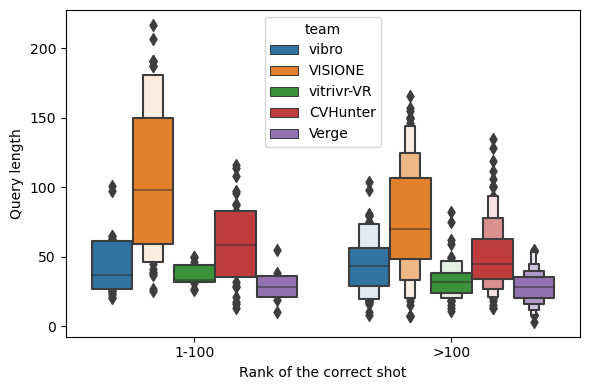

In [407]:
textData = dataset.loc[dataset["query_type"]=="CLIP"]
textData["rankCat"] = ">100"
textData.loc[(textData.rank_shot_margin_0 <= 100),"rankCat"] = "1-100"

fig,ax = plt.subplots(1,1, figsize=(6,4))
textDataWithLength = textData.loc[textData.QueryLen > -1] # just to be sure
hue_order = team_order

#sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryWords", hue="team", ax=ax, hue_order = hue_order)
sns.boxenplot(data=textDataWithLength,x="rankCat",y="QueryLen", hue="team", ax=ax, hue_order = hue_order)

#ax.set_xlabel("Rank of the correct shot")
ax.set_xlabel("Rank of the correct shot")
#ax.set_ylabel("Words per query")
ax.set_ylabel("Query length")
plt.tight_layout()
plt.savefig("kis_TextQueryLengthVsRanking.pdf")